<a href="https://colab.research.google.com/github/Ashidhi/Titanic-ML-Project/blob/main/improved%20titanic%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Titanic Survival Prediction - Improved Version

# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Upload Titanic dataset files
from google.colab import files

uploaded = files.upload()
# 2. Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Random Forest Accuracy: 0.8491620111731844
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       105
           1       0.83      0.80      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



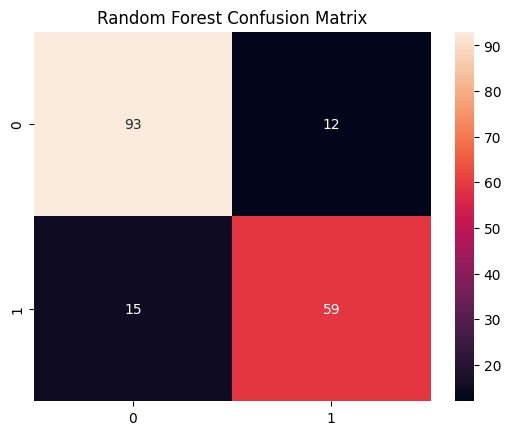

Logistic Regression Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



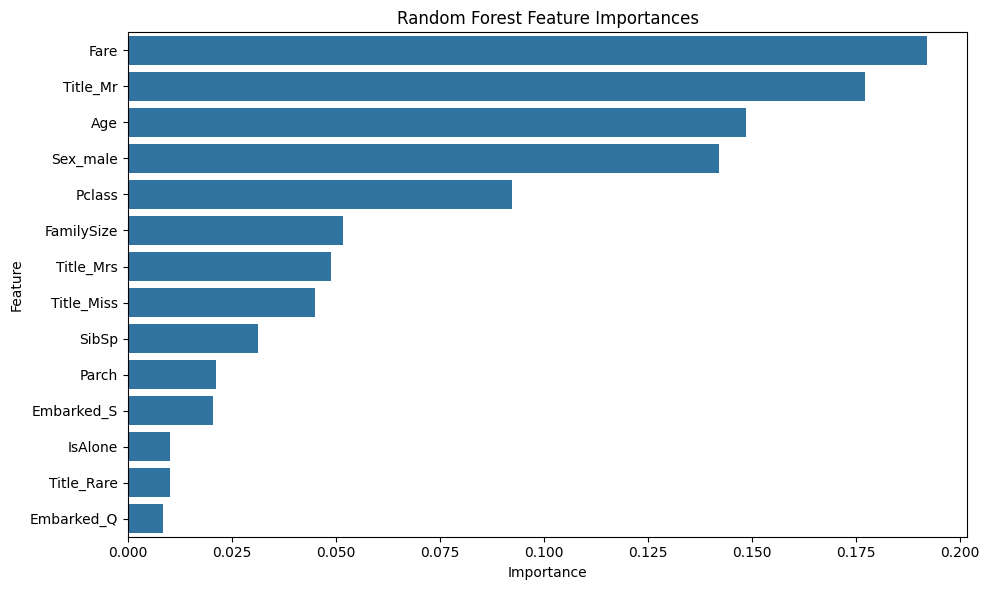

In [7]:


# 3. Data Cleaning & Preprocessing
def preprocess(df):
    df = df.copy()  # avoid chained assignment issues

    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    df.drop('Cabin', axis=1, inplace=True)

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

    return df


train = preprocess(train)
test = preprocess(test)

# 4. Feature Selection
features = [
    'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone',
    'Sex_male', 'Embarked_Q', 'Embarked_S',
    'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
X = train[features]
y = train['Survived']

# 5. Split Train/Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Random Forest with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# 7. Evaluation
y_pred = best_rf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# 8. Logistic Regression for Comparison
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print("Logistic Regression Accuracy:", logreg.score(X_val, y_val))
print(classification_report(y_val, logreg.predict(X_val)))

# 9. Feature Importances
feat_imp = pd.DataFrame({'Feature': features, 'Importance': best_rf.feature_importances_})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# 10. Prepare Test Data & Submission
test_X = test[features]
test_preds = best_rf.predict(test_X)
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_preds
})
submission.to_csv('submission.csv', index=False)


In [8]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [9]:
print("Survival Rate in Predictions:", submission['Survived'].mean())

Survival Rate in Predictions: 0.36363636363636365


In [10]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>